# GleanerIO SHACL processor

## About

Ted Habberman presented to the CDF on ISO metadata analysis.  I have been exploring some approaches to accessing the FAIR Digital Object server that is part of the standard setup supporting GeoCODES and other groups.  Leveraging Python Dask and S3 Boto it is easy to access these object stores in a highly performant manner.  

In addition to DASK there is S3SELECT as well as SPARQL calls on objects and triplestores.  

## Notes

Curious above local context file reading when doing lots of calls.  PyLD seems to know to do caching but not sure how it could in a Dask based pattern.

May need to explore approach to read local files for context like

Use for reports, FPDFF:  https://pyfpdf.readthedocs.io/en/latest/Tutorial/index.html

## Imports


In [71]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning

import dask
import boto3
import pandas as pd
import json
import s3fs
import kglab
import seaborn as sns
from rdflib import Graph  #, plugin
import getpass
import plotly.express as px
import matplotlib.pyplot as plt


import time
from datetime import datetime
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter
from reportlab.platypus import *
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch

## Set up Dask client

In [33]:
from dask.distributed import Client    #, progress
client = Client(threads_per_worker=5, n_workers=4)
client

/home/fils/.conda/envs/kglab/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39081 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:39081/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:39081/status,Workers: 4
Total threads: 20,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:44361,Workers: 4
Dashboard: http://127.0.0.1:39081/status,Total threads: 20
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:37229,Total threads: 5
Dashboard: http://127.0.0.1:36343/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:44885,


## File Access

In [34]:
# ## Anonymous S3 File system
# oss = s3fs.S3FileSystem(
#     anon=True,
#     client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
# )

# Access controlled s3
session = boto3.Session(profile_name='default' ,   region_name="us-east-1")
s3 = session.client('s3')  # needed later for listing objects
s3r = session.resource('s3')
oss = s3fs.S3FileSystem( profile="default")

## Manual code access
# ACCESS_CODE = getpass.getpass()
# SECRET_CODE = getpass.getpass()
#
# oss = s3fs.S3FileSystem(
#     anon=False,
#     key=ACCESS_CODE,
#     secret=SECRET_CODE,
#     client_kwargs = {"endpoint_url":"http://192.168.202.114:49155"}
# )

In [35]:
# [optional] List the directories we can work with later
# sumlist = oss.ls('gleaner/summoned')
sumlist = oss.ls('gleaner.oih/summoned/')
print(sumlist)

['gleaner.oih/summoned/aquadocs', 'gleaner.oih/summoned/edmerp', 'gleaner.oih/summoned/edmo', 'gleaner.oih/summoned/invemardocuments', 'gleaner.oih/summoned/invemarexpert', 'gleaner.oih/summoned/invemarinstitution', 'gleaner.oih/summoned/invemartraining', 'gleaner.oih/summoned/invemarvessel', 'gleaner.oih/summoned/marinetraining', 'gleaner.oih/summoned/obis', 'gleaner.oih/summoned/obps']


### Definitions

In [58]:
# SHACL function
@dask.delayed()
def read_and_validate(fn):
    # make a kg to hold our data graph
    namespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org based datagraph",
        base_uri = "https://example.org/id/",
        namespaces = namespaces,
    )

    ## this is a mess.   no need to load to a graph objet to validate.  also, 
    ## can we load up the graph first and then validate later for everythng?
    with oss.open(fn, 'rb') as f:
        jld = json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))
        jlds = json.dumps(jld)

        g = Graph().parse(data=jlds, format='json-ld')
        context = {
            "@vocab": "https://schema.org/",
        }

        ttl = g.serialize(format='ttl', context=context, indent=4)
        kg.load_rdf_text(ttl, format="ttl", base=None)

        conforms, report_graph, report_text = kg.validate(
            shacl_graph=sg,
            shacl_graph_format="ttl"
        )

        return report_graph.save_rdf_text()  # return graph object or string of graph

## Set variables for run targets

In [78]:
# Set the shapegraph to use
sg = './shapes/geocodes_dcscan.ttl'  # soso_common_v1.2.3.ttl   geocodes_dcscan.ttl
sgurl = sg

# which of the above prefix to check
checkPrefix = "gleaner.oih/summoned/obis"

now = datetime.now()
date_time = now.strftime("%m-%d-%Y-%H-%M-%S")

## Process the files via Dask


In [63]:
%%time

fns = oss.ls(checkPrefix)
o = [read_and_validate(f) for f in fns]
results = dask.compute(*o)

CPU times: user 11.8 s, sys: 1.14 s, total: 13 s
Wall time: 48.1 s


### Loop on results and load to graph

In [72]:
rnamespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

kg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = rnamespaces,
)

for r in results:
    kg.load_rdf_text(data=r, format="ttl")

severity                                 sh:Info  sh:Violation  sh:Warning
message                                                                   
@id should be provided                         0          4426           0
Included variableMeasured, if available     4426             0           0
Name is required                               0            11           0
Resource must have a description               0            11           0
Resource must have an identifier node          0             0        4426
Resource must have one or more keywords        0            18           0
distribution required                          0             0        4426


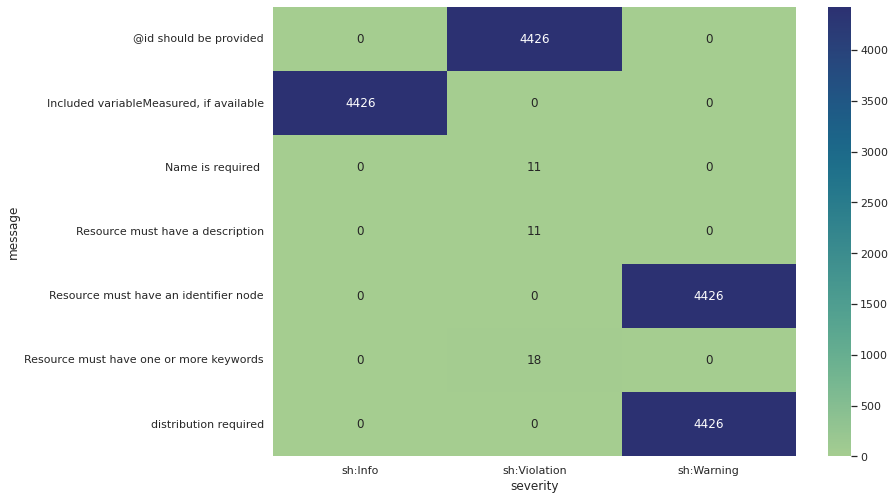

In [80]:
sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

pdf = kg.query_as_df(sparql)
df = pdf.to_pandas()  #  breaks with papermill for reasons unknown at this time if to_pandas() is used, needed in my kglab conda env

if 'severity' in df.columns:
    dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
    ctst = pd.crosstab(df['message'], df['severity'],  margins = False , margins_name = 'Totals')

    # s1 = str("Checking {} object(s)".format(len(dg) ))
    s1 = "Checking obects"
    # print(s1)
    print(ctst)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)
    plt.savefig('./output/heatmap_{}.png'.format(date_time))
else:
    print("No severity column found, all SHACL validations must have passed OR a processing error occurred upstream")

In [81]:
# build report
Story=[]

styles = getSampleStyleSheet()
HeaderStyle = styles["Heading1"]
ParaStyle = styles["Normal"]
PreStyle = styles["Code"]

def header(txt, style=HeaderStyle, klass=Paragraph, sep=0.3):
    s = Spacer(0.2*inch, sep*inch)
    para = klass(txt, style)
    sect = [s, para]
    result = KeepTogether(sect)
    return result

def pre(txt):
    s = Spacer(0.1*inch, 0.1*inch)
    p = Preformatted(txt, PreStyle)
    precomps = [s,p]
    result = KeepTogether(precomps)
    return result

doc = SimpleDocTemplate("./output/report_{}.pdf".format(date_time),pagesize=letter,
                        rightMargin=72,leftMargin=72,
                        topMargin=72,bottomMargin=18)

logo = './output/heatmap_{}.png'.format(date_time)
im = Image(logo, 4*inch, 3*inch)

address_parts = ["RunID: {}".format(date_time), "Shape graph: {}".format(sgurl)]

styles=getSampleStyleSheet()
styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))



# Create return address
full_name = "Validation report"
ptext = '%s' % full_name
Story.append(Paragraph(ptext, styles["Heading1"]))

# add date and time
formatted_time = time.ctime()
ptext = '%s' % formatted_time
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 12))

for part in address_parts:
    ptext = '%s' % part.strip()
    Story.append(Paragraph(ptext, styles["Normal"]))

Story.append(Spacer(1, 12))
ptext = 'There were validation issues with the following resources.  They were not able to be checked'
Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))
# for part in fna:
#     ptext = '%s' % part.strip()
#     Story.append(Paragraph(ptext, styles["Code"]))

Story.append(Spacer(1, 12))

ptext = 'This is a validation report using pySHACL to process the provided data graphs \
        against the noted shape graph.  A heat map of the results is seen below to provide \
        a quick over view.  However, the details are easier to leverage from the generated \
        CSV document that will come with this report. '

Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))

Story.append(Paragraph(s1, styles["Justify"]))
Story.append(Spacer(1, 12))

# Story.append(Paragraph(str(ctst), styles["Code"]))
# Story.append(Spacer(1, 12))

# Add the image
Story.append(im)

ptext = 'For more information about validation please visit the project documentation.  \
        Details of the errors reported can be found in the shape file documentation page.'
Story.append(Paragraph(ptext, styles["Justify"]))

# Create return address
Story.append(Spacer(1, 12))
full_name = "Details"
ptext = '%s' % full_name
Story.append(Paragraph(ptext, styles["Heading1"]))

ptext = 'Details of the detected violations and the associated reference node are found in the CSV \
        that accompany this report:  validationReport_{}.csv '.format(date_time)

Story.append(Paragraph(ptext, styles["Justify"]))

doc.build(Story)


In [82]:
# TODO export to parquet and or CSV
# df.to_parquet("./output/eco_opentopo_SHACL.parquet")
df.to_csv("./output/validationReport_{}.csv".format(date_time))